<a href="https://colab.research.google.com/github/LinjingBi/practice-nn-0-to-hero/blob/master/L3_makemore_part2_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In part 1, we build a mini MLP:
str -> 0D integer -> one-hot encoding(27 length) -> one hidden layer(with 27 neurons. no activation function. outputs are X@W) -> softmax -> cross entropy loss -> gradient descent.

Now for part 2, we want to add an embedding layer("a learned distributed feature vector, to represent similarity between words") between one-hot encoding and dense layer. This idea is from this paper
https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf
and the embedding layer is the mapping C.
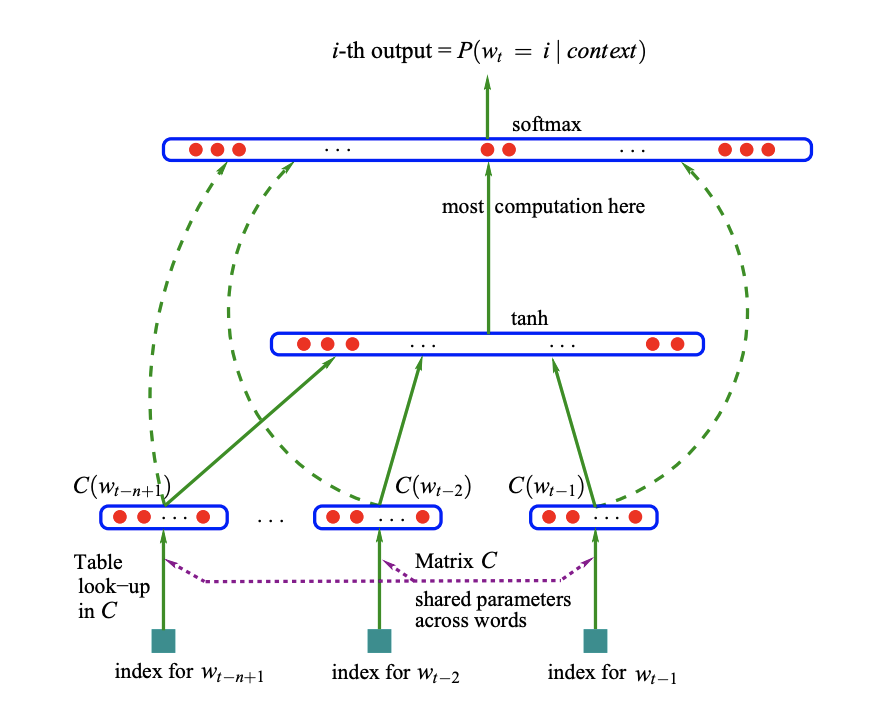



In [3]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [4]:
with open('names.txt') as f:
  names = f.read().splitlines()
vocab = sorted(set("".join(names)))

str2in = {j: i+1 for i, j in enumerate(vocab)}
str2in['.'] = 0
in2str = {v: k for k, v in str2in.items()}


MLP for predicting 1 next letter with # of blocks letters given.



In [32]:
"""generate training set
f.e. sara.
input  target
... -> s
..s -> a
.sa -> r
sar -> a
ara -> .
"""
blocks = 3  # use 3 inputs to predict 1 output
def build_dataset(inputs):
  xs, ys = [], []
  for item in inputs:
    x = [0] * blocks
    for l in item + '.':  # don't forget .
      y = str2in[l]
      xs.append(x)
      ys.append(y)
      x = x[1:] + [y]

  return torch.tensor(xs), torch.tensor(ys)

# separate training data(80%), dev data(10%), test data(10%)
import random
random.seed(42)
random.shuffle(names)

n1 = int(0.8*len(names))
n2 = int(0.9*len(names))

X_tr, Y_tr = build_dataset(names[:n1])
X_dev, Y_dev = build_dataset(names[n1:n2])
X_test, Y_test = build_dataset(names[n2:])
print(f"training dataset: {X_tr.shape} {Y_tr.shape}\n dev: {X_dev.shape} {Y_dev.shape}\n test: {X_test.shape} {Y_test.shape}")


training dataset: torch.Size([182517, 3]) torch.Size([182517])
 dev: torch.Size([22700, 3]) torch.Size([22700])
 test: torch.Size([22929, 3]) torch.Size([22929])


In [35]:
"""model parameters"""
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((27, 10), generator=g) # idx to vector mapping table
W1 = torch.randn((30, 200), generator=g) # 100 neurons, each has 6 weights from 3*2
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, W2, b1, b2]
# !!!! don't forget require grad for all parameters
for p in parameters:
  p.requires_grad = True

In [36]:
"""train"""
steps = []
losses = []
for i in range(200000):
  # select batch input from X_tr
  idxs = torch.randint(0, X_tr.shape[0], (32,))

  # embedding layer 3
  emb = C[X_tr[idxs]]  # (32, 3, 10) # turn one idx to a vector, f.e. 1 -> [0.3, 0.8]

  # dense layer
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)

  # logits
  logits = h @ W2 + b2 # (32, 27)

  # loss
  loss = F.cross_entropy(logits, Y_tr[idxs])
  # print(loss.item())

  # backward pass
  for p in parameters:
    p.grad = None  # zero grad first
  loss.backward()
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr*p.grad # gradient descent

  # for plot
  steps.append(i)
  losses.append(loss.log10().item())

print(loss.item())

2.009902238845825


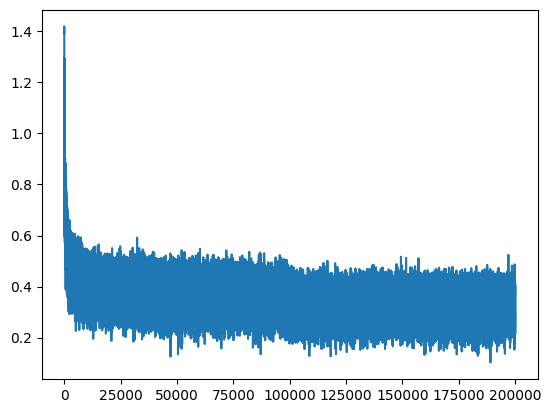

In [37]:
plt.plot(steps, losses)

In [38]:
"""Test with all train data to check loss"""
# embedding layer 3
emb = C[X_tr]  # (12, 3, 2) # turn one idx to a vector, f.e. 1 -> [0.3, 0.8]

# dense layer
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (12, 100)

# logits
logits = h @ W2 + b2 # (12, 27)

# loss
loss = F.cross_entropy(logits, Y_tr)
loss

tensor(2.1219, grad_fn=<NllLossBackward0>)

In [39]:
"""test with dev data for loss"""
# embedding layer 3
emb = C[X_dev]  # (12, 3, 2) # turn one idx to a vector, f.e. 1 -> [0.3, 0.8]

# dense layer
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (12, 100)

# logits
logits = h @ W2 + b2 # (12, 27)

# loss
loss = F.cross_entropy(logits, Y_dev)
loss

tensor(2.1785, grad_fn=<NllLossBackward0>)

In [40]:
"""sample from test data"""
# sample from the model
# g = torch.Generator().manual_seed(2147483647 + 11)
x = [0]*blocks

for _ in range(50):
  out = ''
  while True:
    X = torch.tensor([x])
    xenc = C[X] # (1, 3, 10)
    xemb = F.tanh(xenc.view(-1, 30)@W1 + b1)  # (1, 200)
    logits = xemb @ W2 + b2  # (1, 27)
    # idx = torch.multinomial(F.softmax(logits, dim=1), num_samples=1, generator=g).item()
    idx = torch.multinomial(F.softmax(logits, dim=1), num_samples=1).item()
    x = x[1:] + [idx]
    out += in2str[idx]
    if idx == 0:
      break

  print(out)




jahjamylenni.
sevian.
alonelenious.
cerykensa.
f.
pprimuna.
ieony.
sen.
cell.
eimaylie.
selen.
ter.
ppranciol.
cin.
sohee.
yeilanillia.
una.
ufena.
ina.
indalet.
cerikaylina.
inleilana.
ier.
phlyn.
celanestori.
somirlam.
endory.
sere.
.
elinat.
ynvi.
philkota.
inly.
serokahay.
aliza.
inverion.
ceara.
ondreesana.
ies.
ceson.
celie.
seran.
uel.
.
wec.
soni.
sella.
onana.
aliyanna.
inra.


In [ ]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
# only availabe when C is (27,2).
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), in2str[i], ha="center", va="center", color='white')
plt.grid('minor')

Training review  
1. start with learning rate at 0.01 and run for 2000 times, if loss is not ideal(f.e.<~2.45).
2. add more loop
3. still not ideal
  1. try a range of learning rate(0.001, 0.01, 0.1, 1), find a proper value(f.e. 0.1 here)
  2. if 1. is still not good, start updating paramaters in layers close to output: f.e. adding more neurons in embedding layer(f.e. change W1 from 100 to 200).
  3. if 2. turns out not good, start changing parameters related to C(f.e. from 2D to 10D)
  4. if 3 is not enough, like in the latest part of the training, the lose is up and down from time to time, use dynamic learning rate.(f.e. first half of the training is 0.1 and the second half is 0.01)

Always plot step vs loss for monitoring.

In [ ]:
# some PyTorch syntax

# torch.zeros(), torch.ones()
# torch.randn((dims)) generate random n dims tensor
# torch.tensor() dump input into tensor
# torch.arange(start, end, step). 1D tensor
# torch.randint(start, end, shape) integer from start to end in size
# torch.tanh() tanh func
# torch.tensor().view(-1, 6) reshape tensor
# torch.Generator().manual_seed(2147483647)
# F.cross_entropy() calculate loss
# torch.multinomial(). used for sampling from probs